In [1]:
import sys
import os

# Проверяем, выполняется ли код в Google Colab, и настроено ли окружение
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    # Загружаем и выполняем скрипт для настройки Colab из репозитория Yandex Data School
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    # Создаем файл-маркер, чтобы избежать повторной настройки
    !touch .setup_complete

# Проверяем, доступен ли графический дисплей в системе
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    # Если графический дисплей отсутствует, запускаем виртуальный дисплей с помощью xvfb
    !bash ../xvfb start
    # Устанавливаем переменную окружения DISPLAY для работы графических приложений
    os.environ['DISPLAY'] = ':1'

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 123633 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfon

# Approximate q-learning (10 pts)

In this notebook you will teach a __PyTorch__ neural network to do Q-learning.

In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Настраиваем отображение графиков непосредственно в ноутбуке
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns 

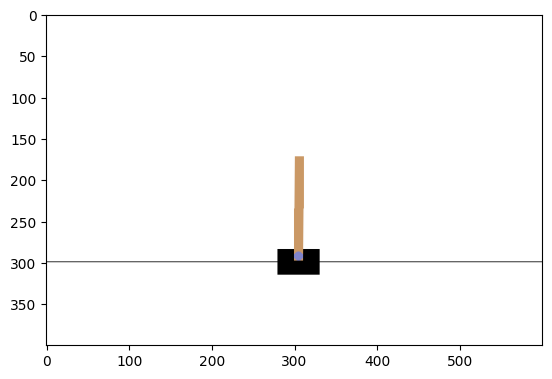

In [3]:
import gym
import matplotlib.pyplot as plt

# Создаем окружение "CartPole-v0"
env = gym.make("CartPole-v0").env

# Сбрасываем состояние окружения для начала новой игры
env.reset()

# Получаем количество возможных действий в среде
n_actions = env.action_space.n

# Получаем размерность наблюдений из среды
state_dim = env.observation_space.shape

# Отображаем текущее состояние окружения в виде изображения
plt.imshow(env.render("rgb_array"))

# Закрываем окружение после завершения работы
env.close()

# Approximate Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/yet_another_week/_resource/qlearning_scheme.png)

For your first run, please only use linear layers (`nn.Linear`) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly.

Also please avoid using nonlinearities like sigmoid & tanh: since agent's observations are not normalized, sigmoids might be saturated at initialization. Instead, use non-saturating nonlinearities like ReLU.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import torch.nn as nn

# Создаем последовательную нейронную сеть
network = nn.Sequential()

# Первый полносвязный слой, преобразующий входное состояние в 128-мерный вектор
network.add_module('layer1_1', nn.Linear(state_dim[0], 128))
# Функция активации ReLU после первого слоя
network.add_module('relu1_1', nn.ReLU())

# Второй полносвязный слой, уменьшающий размерность до 64
network.add_module('layer1_2', nn.Linear(128, 64))
# Функция активации ReLU после второго слоя
network.add_module('relu1_2', nn.ReLU())

# Третий полносвязный слой, уменьшающий размерность до 32
network.add_module('layer1_3', nn.Linear(64, 32))
# Функция активации ReLU после третьего слоя
network.add_module('relu1_3', nn.ReLU())

# Выходной слой, преобразующий 32-мерный вектор в количество действий в среде
network.add_module('output_layer', nn.Linear(32, n_actions))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
import numpy as np
import torch

# Функция для выбора действия с использованием epsilon-жадной стратегии
def get_action(state, epsilon=0):
    """
    Выбирает действие с использованием epsilon-жадной политики.
    Если случайное число < epsilon, выбирается случайное действие.
    Иначе выбирается действие с наибольшим значением Q(s, a).

    Параметры:
    state (array): Текущее состояние среды.
    epsilon (float): Вероятность выбора случайного действия (по умолчанию 0).

    Возвращает:
    int: Выбранное действие.
    """
    # Преобразуем состояние в тензор с дополнительной размерностью для батча
    state = torch.tensor(state[None], dtype=torch.float32)

    # Получаем Q-значения для текущего состояния
    q_values = network(state).detach().numpy()

    # С вероятностью epsilon выбираем случайное действие
    if np.random.rand() < epsilon:
        action = np.random.randint(0, q_values.shape[1])
    else:
        # Иначе выбираем действие с максимальным Q-значением
        action = np.argmax(q_values)

    return int(action)


In [7]:
# Сбрасываем окружение и получаем начальное состояние
s = env.reset()

# Проверка: модель должна преобразовывать состояние s в Q-значения для всех действий
assert tuple(network(torch.tensor([s]*3, dtype=torch.float32)).size()) == (3, n_actions), \
    "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"

# Проверка: последний слой сети должен быть линейным (без нелинейности)
assert isinstance(list(network.modules())[-1], nn.Linear), \
    "please make sure you predict q-values without nonlinearity (ignore if you know what you're doing)"

# Проверка: функция get_action должна возвращать целое число
assert isinstance(get_action(s), int), \
    "get_action(s) must return int, not %s. try int(action)" % (type(get_action(s)))

# Тестирование epsilon-жадной стратегии
for eps in [0., 0.1, 0.5, 1.0]:
    # Считаем частоты выбора действий при данном epsilon
    state_frequencies = np.bincount(
        [get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions
    )

    # Определяем лучшее действие (действие с наибольшей частотой выбора)
    best_action = state_frequencies.argmax()

    # Проверяем, что частота лучшего действия соответствует теоретическим ожиданиям
    assert abs(state_frequencies[best_action] - 10000 * (1 - eps + eps / n_actions)) < 200

    # Проверяем, что частоты остальных действий также соответствуют ожиданиям
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / n_actions)) < 200

    print('e=%.1f tests passed' % eps)

<ipython-input-7-6783711dfa11>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  assert tuple(network(torch.tensor([s]*3, dtype=torch.float32)).size()) == (3, n_actions), \


e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable.

To do so, we shall use `x.detach()` function which basically says "consider this thing constant when doingbackprop".

In [8]:
import torch

def compute_td_loss(states, actions, rewards, next_states, is_done, gamma=0.99, check_shapes=False):
    """
    Вычисление TD-ошибки с использованием операций PyTorch.

    Параметры:
    states (array): Набор текущих состояний.
    actions (array): Действия, выполненные в данных состояниях.
    rewards (array): Вознаграждения, полученные за действия.
    next_states (array): Следующие состояния после выполнения действий.
    is_done (array): Флаг завершения эпизода (1, если эпизод завершён).
    gamma (float): Коэффициент дисконтирования (по умолчанию 0.99).
    check_shapes (bool): Проверка корректности размерностей тензоров (по умолчанию False).

    Возвращает:
    torch.Tensor: Значение функции потерь.
    """
    # Преобразуем входные данные в тензоры
    states = torch.tensor(states, dtype=torch.float32)  # [batch_size, state_size]
    actions = torch.tensor(actions, dtype=torch.long)   # [batch_size]
    rewards = torch.tensor(rewards, dtype=torch.float32)  # [batch_size]
    next_states = torch.tensor(next_states, dtype=torch.float32)  # [batch_size, state_size]
    is_done = torch.tensor(is_done, dtype=torch.uint8)  # [batch_size]

    # Вычисляем Q-значения для всех действий в текущих состояниях
    predicted_qvalues = network(states)

    # Выбираем Q-значения для выполненных действий
    predicted_qvalues_for_actions = predicted_qvalues[range(states.shape[0]), actions]

    # Вычисляем Q-значения для всех действий в следующих состояниях
    predicted_next_qvalues = network(next_states)

    # Вычисляем V*(next_states) как максимум Q-значений по всем действиям
    next_state_values = predicted_next_qvalues.max(dim=1)[0]
    assert next_state_values.dtype == torch.float32

    # Вычисляем целевые Q-значения для функции потерь
    target_qvalues_for_actions = rewards + (1 - is_done.float()) * gamma * next_state_values

    # Для терминальных состояний Q(s, a) = r(s, a)
    target_qvalues_for_actions = torch.where(is_done, rewards, target_qvalues_for_actions)

    # Среднеквадратичная ошибка между предсказанными и целевыми Q-значениями
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        # Проверка: Q-значения для всех действий в следующих состояниях имеют размерность 2
        assert predicted_next_qvalues.data.dim() == 2, "make sure you predicted q-values for all actions in next state"
        # Проверка: V(s') вычислено как максимум по оси действий
        assert next_state_values.data.dim() == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        # Проверка: целевые Q-значения являются вектором
        assert target_qvalues_for_actions.data.dim() == 1, "there's something wrong with target q-values, they must be a vector"

    return loss


In [9]:
# Проверка корректности работы compute_td_loss
s = env.reset()
a = env.action_space.sample()
next_s, r, done, _ = env.step(a)
loss = compute_td_loss([s], [a], [r], [next_s], [done], check_shapes=True)
loss.backward()

# Проверяем, что функция возвращает скалярную ошибку (усреднённую по батчу)
assert len(loss.size()) == 0, "you must return scalar loss - mean over batch"

# Проверяем, что ошибка является дифференцируемой по весам сети
assert np.any(next(network.parameters()).grad.detach().numpy() != 0), \
    "loss must be differentiable w.r.t. network weights"

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-8-0edc4240fa75>:43: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:530.)
  target_qvalues_for_actions = torch.where(is_done, rewards, target_qvalues_for_actions)


### Playing the game

In [10]:
opt = torch.optim.Adam(network.parameters(), lr=1e-4) # Оптимизатор для обновления параметров сети

In [11]:
def generate_session(env, t_max=1000, epsilon=0, train=False):
    """Играем в среде с использованием агента на основе Q-learning и, при необходимости, обучаем его."""
    total_reward = 0
    s = env.reset()

    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)  # Получаем действие с учётом epsilon-жадной стратегии
        next_s, r, done, _ = env.step(a)  # Выполняем действие

        if train:
            # Обучение нейронной сети
            opt.zero_grad()
            compute_td_loss([s], [a], [r], [next_s], [done]).backward()
            opt.step()

        total_reward += r  # Суммируем награды
        s = next_s  # Переходим в следующее состояние
        if done:
            break

    return total_reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
epsilon = 0.5

In [13]:
# Запуск обучения агента с отображением результатов
for i in range(1000):
    session_rewards = [generate_session(env, epsilon=epsilon, train=True) for _ in range(100)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))

    epsilon *= 0.99  # Постепенное уменьшение epsilon для уменьшения вероятности случайных действий
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"

    if np.mean(session_rewards) > 300:
        print("You Win!")
        break


epoch #0	mean reward = 14.110	epsilon = 0.500
epoch #1	mean reward = 13.540	epsilon = 0.495
epoch #2	mean reward = 13.910	epsilon = 0.490
epoch #3	mean reward = 14.190	epsilon = 0.485
epoch #4	mean reward = 15.110	epsilon = 0.480
epoch #5	mean reward = 21.130	epsilon = 0.475
epoch #6	mean reward = 34.780	epsilon = 0.471
epoch #7	mean reward = 47.630	epsilon = 0.466
epoch #8	mean reward = 58.350	epsilon = 0.461
epoch #9	mean reward = 75.600	epsilon = 0.457
epoch #10	mean reward = 72.220	epsilon = 0.452
epoch #11	mean reward = 103.840	epsilon = 0.448
epoch #12	mean reward = 110.050	epsilon = 0.443
epoch #13	mean reward = 129.650	epsilon = 0.439
epoch #14	mean reward = 131.680	epsilon = 0.434
epoch #15	mean reward = 159.640	epsilon = 0.430
epoch #16	mean reward = 155.470	epsilon = 0.426
epoch #17	mean reward = 186.000	epsilon = 0.421
epoch #18	mean reward = 175.420	epsilon = 0.417
epoch #19	mean reward = 174.670	epsilon = 0.413
epoch #20	mean reward = 261.810	epsilon = 0.409
epoch #21	mea

### How to interpret results


Welcome to the f.. world of deep f...n reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* __ mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture.
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.